# Today you are a Machine Learning Engineer at the Perception team that works on iphone cameras. Your goal is to transfer learning from existing object detector models to automatically detect pets (dog in this example) when you point your camera in a certain direction. 
### You need to learn from a few image samples and quickly adapt your detector.
This assignment is based on the Few-Shot Method in https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

# You have 2 major Tasks to fulfill:
## 1. Retrain an object detector using a small subset of training data (10 images here) to detect a particular class object only.
## 2. Report the accuracy/perfromance of the new object detector.

Lets begin with the Tasks now...

# Task 0: Getting to know the Data
## 1. Import Libraries and Dependencies

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [2]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1606783 sha256=4091b9ff824873f1be80e7700ff3a08e3bdd3cfd832bfe1fd45cf4f1a93309e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-k85lj3u4/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
#from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [4]:
from google.colab import drive
# Your drive might be named 'gdrive' rather than 'drive'
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls
!ls drive
!ls drive/MyDrive/Colab\ Notebooks/Week\ 6

drive	     ssd_resnet50_v1_fpn_640x640_coco17_tpu-8
models	     ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
sample_data
MyDrive
dog_dataset  MLE@Apple_cameras_team_v1.ipynb  visualization_utils.py


## 2. Understanding the Utilities (helper functions)

### The format for annotated bounding boxes=[ymin,xmin,ymax,xmax]
### If the annotations are in decimals (normalized annotations), the bounding box surfaces (left, right, top and bottom surfaces) are scaled with respect to the original image width $w$ and height $h$ as follows:
left=$x_{min}*w$, 
right=$x_{max}*w$, 
top=$y_{min}*h$, 
bottom=$y_{max}*h$, 

More details of implementation for bounding box visualization resides in the function: draw_bounding_box_on_image

In [6]:
#This function reads images and creates a list of image array
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

#This function plots the bounding box on the images
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True, #This parameter determines if the bbox coordinates are normalized or not
      min_score_thresh=0.6)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Task 1: Prepare the training and test data sets

Number of taining images= 10


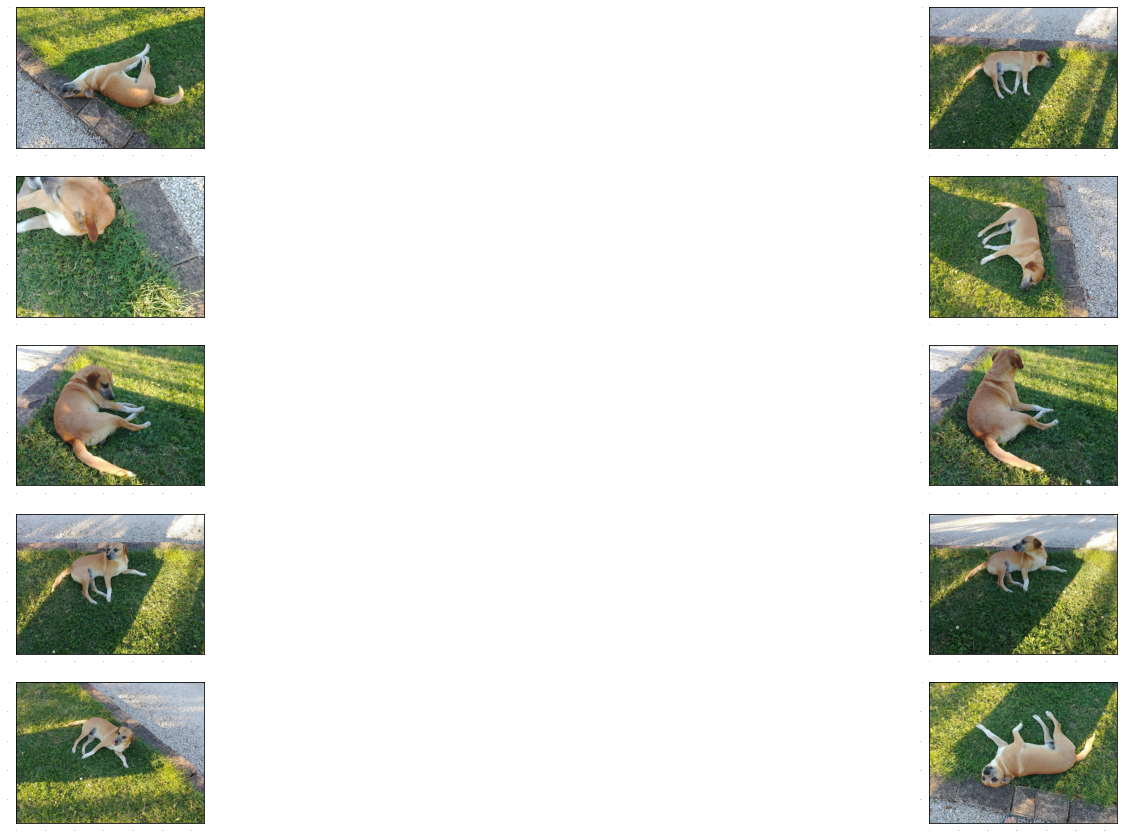

(10, 480, 640, 3)


In [7]:
#1. Load training images and visualize
######START CODE HERE################
train_image_dir = os.path.join('drive', 'MyDrive', 'Colab Notebooks', 'Week 6', 'dog_dataset', 'train', 'images')
#Find how many images, num
image_names = sorted(os.listdir(train_image_dir))
num = len(image_names)
######END CODE HERE################
print('Number of taining images=',num)
train_images_np = []
for i in image_names:
  image_path = os.path.join(train_image_dir, i)
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [30, 15]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(5, 2, idx+1)
  plt.imshow(train_image_np)
plt.show()
train_images_np = np.array(train_images_np)
print(train_images_np.shape)

In [8]:
#2. Return the shape of each image (width (w) and height(h)). 
#This will be used to scale the bounding boxes for visualization
#####START CODE HERE#######
w=train_images_np[0].shape[1]
h=train_images_np[0].shape[0]
###########END CODE HERE

print(w,h)

640 480


In [9]:
#Next, read the annotations from the xml file
import xml.etree.ElementTree as ET

#This function parses xlm file to extract bounding box cooredinates [ymin,xmin,ymax,xmax]
def read_content(xml_file: str,w,h):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None
        #Normalize the boxes

        ymin = int(boxes.find("bndbox/ymin").text)/h
        xmin = int(boxes.find("bndbox/xmin").text)/w
        ymax = int(boxes.find("bndbox/ymax").text)/h
        xmax = int(boxes.find("bndbox/xmax").text)/w
        
        

        list_with_single_boxes = [ymin, xmin, ymax, xmax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes


#Now call the function above to read the annotations
##################START CODE HERE
train_ann_dir = os.path.join('drive', 'MyDrive', 'Colab Notebooks', 'Week 6', 'dog_dataset', 'train', 'annotations')

# Old code from when I was trying to figure out what read_content did.
#gt_boxes = []
#for xml_file in sorted(os.listdir(train_ann_dir)):
#    filename, list_with_all_boxes = read_content(os.path.join(train_ann_dir, xml_file), w, h)
#    print(filename)
#    print(list_with_all_boxes)
#    gt_boxes.append(list_with_all_boxes)
#gt_boxes = np.array(gt_boxes)

gt_boxes = np.array([read_content(os.path.join(train_ann_dir, xml_file), w, h)[1] for xml_file in sorted(os.listdir(train_ann_dir))])
##################END CODE HERE
    

In [10]:
#This code is useful for GLP instantiation. Remove this if using colab
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession

#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [11]:
# 3. Visualize bounding boxes on the training images
dog_class_id = 1
num_classes = 1

category_index = {dog_class_id: {'id': dog_class_id, 'name': 'dog'}}

# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


In [12]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()
print(gt_boxes[0])

Output hidden; open in https://colab.research.google.com to view.

## Similarly read test data and test annotations

Number of test images= 40


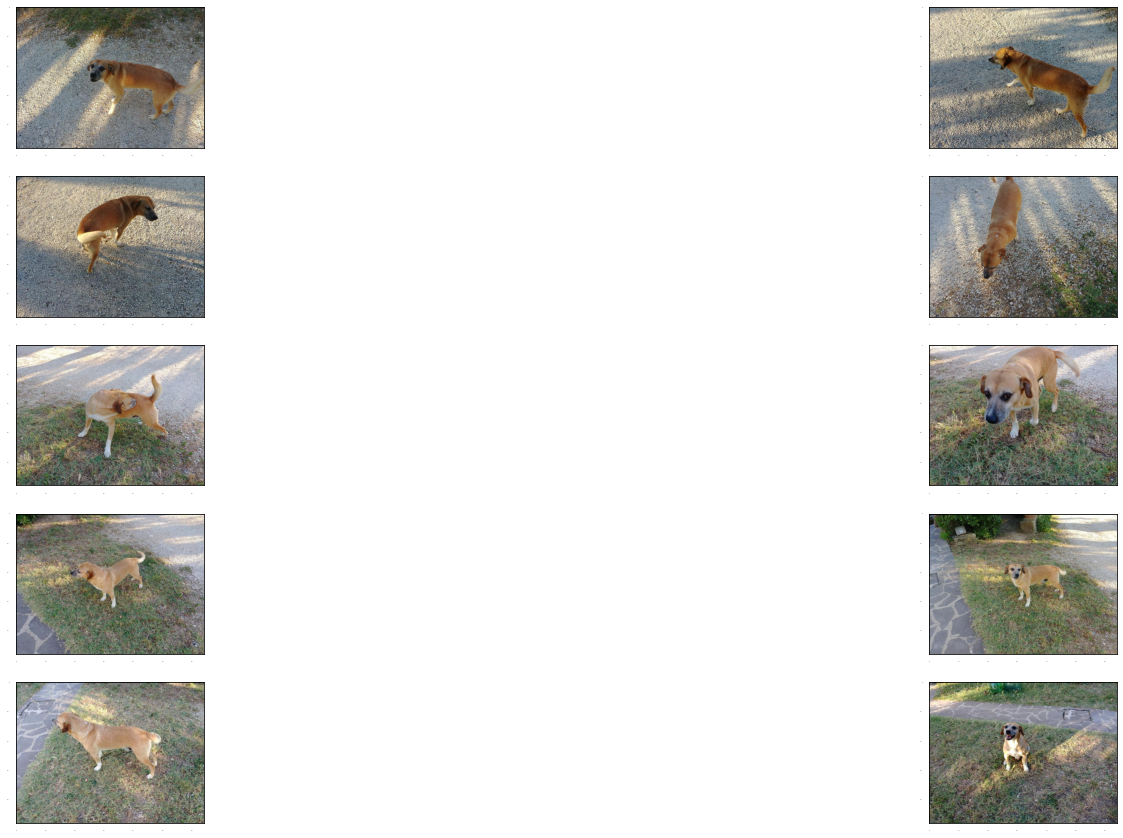

(40, 480, 640, 3)


In [13]:
#4. Read test images and annotations. Repeat the process above for the test data set
##################START CODE HERE
test_image_dir = os.path.join('drive', 'MyDrive', 'Colab Notebooks', 'Week 6', 'dog_dataset', 'images')
#Find how many images, num
image_names = sorted(os.listdir(test_image_dir))
num = len(image_names)
print('Number of test images=',num)
test_images_np = []
for i in image_names:
  image_path = os.path.join(test_image_dir, i)
  #tmp = load_image_into_numpy_array(image_path)
  #test_images_np.append(np.expand_dims(tmp, 0))
  test_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [30, 15]

for idx, test_image_np in enumerate(test_images_np[:10]):
  plt.subplot(5, 2, idx+1)
  plt.imshow(test_image_np)
plt.show()
test_images_np = np.array(test_images_np)
print(test_images_np.shape)

In [14]:
test_ann_dir = os.path.join('drive', 'MyDrive', 'Colab Notebooks', 'Week 6', 'dog_dataset', 'annotations', 'xmls')
t_gt_boxes = np.array([read_content(os.path.join(test_ann_dir, xml_file), w, h)[1] for xml_file in sorted(os.listdir(test_ann_dir))])
##################END CODE HERE

In [15]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      test_images_np[idx],
      t_gt_boxes[idx],
      np.ones(shape=[t_gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Task 2: Retrain classifier layer of a pre-trained object detector and Report mean IOU

In [91]:
# 1. Download the checkpoint and put it into models/research/object_detection/test_data/
#The model for this example is SSD object detector with Resnet50 backbone with feature pyramid network.
#You can choose other models here, such as YOLO, fasterRCNN etc from the options.

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-12-06 21:19:05--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.125.128, 2404:6800:4008:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.125.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.1’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  38.1MB/s    in 6.1s    

2020-12-06 21:19:12 (38.1 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.1’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [92]:
#2. Initializing the trained weights to prepare for transfer learning.
#Restore the weights from the model just as done in the tutorial [COPY the CODE FROM THE TUTORIAL] 
#https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [93]:
#Lets look at the model layers
l=len(detection_model.trainable_variables)
print('Number of trainable layers=',l)
for xi in range(l):
    print(detection_model.trainable_variables[xi].name)
    
    
#We will retrain the first 4 layers only!  

Number of trainable layers= 269
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/beta:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/kernel:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/BatchNorm/feature_0/gamma:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/BatchNorm/feature_0/beta:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_2/ke

In [94]:
#3. Retrain WeightSharedConvolutionalBoxHead and WeightSharedConvolutionalClassHead
tf.keras.backend.set_learning_phase(True)

# These model parameters need to be tuned; 
##################START CODE HERE############
batch_size = 4
learning_rate = 1e-4
num_batches = 100
##################END CODE HERE#################

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    
##Notice here that the loss function has 2 components: classification and localization losses    
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Start fine-tuning!
batch 0 of 100, loss=1.1233333
batch 10 of 100, loss=0.9951866
batch 20 of 100, loss=0.8181446
batch 30 of 100, loss=0.58692455
batch 40 of 100, loss=0.45644554
batch 50 of 100, loss=0.3712851
batch 60 of 100, loss=0.30096492
batch 70 of 100, loss=0.27935493
batch 80 of 100, loss=0.28159642
batch 90 of 100, loss=0.25103262
Done fine-tuning!


In [95]:
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

In [ ]:
#4. Run object detector on each test image and visualize the bounding boxes
#Note: For each image 100 anchor boxes are tested for prediction
#Ensure to pick bounding boxes corresponding to detection_scores>0.7 only
preds=[]
label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(np.expand_dims(test_images_np[i], 0), dtype=tf.float32)
  detections = detect(input_tensor)#This stores the 100 bounding boxes produced per image
  #Assign the anchor box corresponding to the detection_scores>0.7 to variable 'preds'.  
  ##################START CODE HERE##########
  indices = detections['detection_scores'] > 0.7
  pred_boxes = detections['detection_boxes'][indices]
  preds.append(pred_boxes)
  ##################END CODE HERE##############
  plt.figure(figsize=(30, 15))
  for idx in range(5):#print 5 vals only
      plot_detections(
        test_images_np[i],
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)
        + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index)
plt.show()  

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#5. Print the predictions for a sample image and notice the differences
preds_res = np.array([p.numpy() for p in preds])
preds_res = np.array([np.squeeze(p) if p.any() else np.zeros((4,)) for p in preds_res])
print(preds_res.shape)
t_gt_boxes=np.squeeze(np.array(t_gt_boxes))
print(preds_res[0])
print(t_gt_boxes[0])
#Notice how similar or dissimilar predicted boxes are w.r.t groundtruth
#The result will change if you chose thershold for selecing boxes <0.7

(40, 4)
[0.36750659 0.3768619  0.79604042 0.99711144]
[0.36875    0.38125    0.79583333 1.        ]


In [ ]:
#6. Finally, Evaluate the IoU between each prediction and groundtruth bounding box. 
metric = tf.keras.metrics.MeanIoU(num_classes=2)
########START CODE HERE
metric.update_state(t_gt_boxes, preds_res)
m=metric.result()
########END CODE HERE
print('Mean IOU=',m)


Mean IOU= tf.Tensor(0.496875, shape=(), dtype=float32)


# Extra Credit

In [16]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow # cv2.imshow does not work on Google Colab notebooks, which is why we are using cv2_imshow instead

In [23]:
DIM = 299

In [76]:
def gradCAM(model, orig, width, height, intensity=0.5, hmap_threshold=0.6, display=True):
  img = image.load_img(orig, target_size=(DIM, DIM))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_93')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap[heatmap < hmap_threshold] = 0
  heatmap = heatmap.reshape((8, 8))
  heatmap_boxes = cv2.resize(heatmap, (width, height))
  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  max_in_row = np.max(heatmap_boxes, axis=1)
  max_in_col = np.max(heatmap_boxes, axis=0)
  xmin = np.where(max_in_col > 0)[0][0]
  xmax = np.where(max_in_col > 0)[0][-1]
  ymin = np.where(max_in_row > 0)[0][0]
  ymax = np.where(max_in_row > 0)[0][-1]

  if display:
    cv2_imshow(cv2.resize(cv2.imread(orig), (width, height)))
    heat_img = cv2.resize(img, (width, height))
    heat_img = cv2.rectangle(heat_img, (xmin, ymin), (xmax, ymax), (0, 255, 0))
    cv2_imshow(heat_img)

  return xmin, ymin, xmax, ymax

In [18]:
!wget https://indiasendangered.com/wp-content/uploads/2011/09/elephant.jpg
!wget https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg
!wget https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png

--2020-12-06 20:09:37--  https://indiasendangered.com/wp-content/uploads/2011/09/elephant.jpg
Resolving indiasendangered.com (indiasendangered.com)... 199.79.62.149
Connecting to indiasendangered.com (indiasendangered.com)|199.79.62.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137242 (134K) [image/jpeg]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>] 134.03K   250KB/s    in 0.5s    

2020-12-06 20:09:38 (250 KB/s) - ‘elephant.jpg’ saved [137242/137242]

--2020-12-06 20:09:38--  https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.115.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.115.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25761 (25K) [image/jpeg]
Saving to: ‘Chinook-On-White-03.jpg’

Chinook-On-White-03 100%[===================>]  25.16K   140KB/s    in 0.2s    

2020-

In [21]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 7s 0us/step


In [78]:
gradCAM(model, "elephant.jpg", w, h)
gradCAM(model, "Chinook-On-White-03.jpg", w, h)
gradCAM(model, "Thinking-of-getting-a-cat.png", w, h)

Output hidden; open in https://colab.research.google.com to view.

In [89]:
box = gradCAM(model, os.path.join(test_image_dir, 'dog_014.jpg'), w, h)
box = gradCAM(model, os.path.join(test_image_dir, 'dog_015.jpg'), w, h)
box = gradCAM(model, os.path.join(test_image_dir, 'dog_016.jpg'), w, h)

Output hidden; open in https://colab.research.google.com to view.

In [86]:
image_names = sorted(os.listdir(test_image_dir))
t_gcam_boxes = []
for i in image_names:
  image_path = os.path.join(test_image_dir, i)
  xmin, ymin, xmax, ymax = gradCAM(model, image_path, w, h, display=False)
  xmin /= w
  xmax /= w
  ymin /= h
  ymax /= h
  row = np.array([ymin, xmin, ymax, xmax])
  t_gcam_boxes.append(np.expand_dims(row, 0))
t_gcam_boxes = np.array(t_gcam_boxes)

redbone
redbone
Rhodesian_ridgeback
dingo
Chesapeake_Bay_retriever
Great_Dane
Chihuahua
boxer
Chesapeake_Bay_retriever
Rhodesian_ridgeback
Chihuahua
Chihuahua
Pembroke
Chihuahua
redbone
Labrador_retriever
dingo
redbone
dingo
dingo
dhole
Labrador_retriever
Labrador_retriever
Brabancon_griffon
dingo
hog
Chihuahua
dingo
dingo
dingo
squirrel_monkey
Italian_greyhound
dingo
basenji
Pembroke
Chihuahua
cairn
Labrador_retriever
Chihuahua
pug


In [87]:
print(t_gt_boxes.shape)
print(t_gcam_boxes.shape)

(40, 1, 4)
(40, 1, 4)


In [88]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      test_images_np[idx],
      t_gcam_boxes[idx],
      np.ones(shape=[t_gcam_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [97]:
metric = tf.keras.metrics.MeanIoU(num_classes=2)
metric.update_state(t_gcam_boxes, preds_res)
m=metric.result()
print('Mean IOU=',m)

NameError: ignored

# Conclusion

We use the gradient class activation map (CAM) to generate bounding boxes around objects when we have unlabeled data. The bounding boxes vary in quality, as shown in some of the gradCAM images with bounding boxes above. Some tuning could be done to improve the bounding boxes, but the real limitation is that the class avtivation map is not a very precise way to generate bounding boxes. We report our final Mean IOU as TODO.

My Google Colab keeps crashing when generating the predictions. I think I'm just running out of memory. I just need the predictions to calculate the updated IOU, otherwise the extra credit is complete.